<a href="https://colab.research.google.com/github/pekova13/ADAMS/blob/main/Prediction_Of_Likes_On_Social_Media.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## 1. Libraries and Functions

#### Libraries

In [ ]:
import pandas as pd
import numpy as np

# Library re provides regular expressions functionality
import re

# Library beatifulsoup4 handles html
from bs4 import BeautifulSoup

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize.treebank import TreebankWordDetokenizer

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

import gensim
from gensim.models import Word2Vec
from gensim import models
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models.keyedvectors import KeyedVectors

import tensorflow
tensorflow.__version__
from tensorflow.python.keras.layers import Input, Dense,Embedding,GRU, Dropout, LSTM, Bidirectional, concatenate, CuDNNLSTM
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.initializers import Constant

from collections import Counter
from sklearn.metrics import mean_squared_error as mse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from tensorflow.keras.callbacks import EarlyStopping
!pip install optuna
import optuna
!pip install googletrans
from googletrans import Translator

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Functions

In [ ]:
def get_mse_on_test_and_validation_set(X_val_num_frame, X_test_num_frame,predictions_val, predictions_test, y_val_orig, y_test_orig, scaler_object):

      """ 
        A function which firstly inversely rescales the generated predictions, then compares them to the true values of the target variable and finally
        outputs the MSE on the validation and the test data

        Parameters:
        X_val_num_frame: a data frame containing the rescaled values of all numeric variables (Length, Responses, Claps) for the validation set
        X_test_num_frame: same as above but for test set
        predictions_val: predictions (scaled) on the validation data
        predictions_test: predictions (scaled) on the test data 
        y_val_orig: a list of the true y values for the validation set
        y_test_orig: a list of the true y values for the validation set
        scaler_object: the scaler used to initially rescale the data

        Output: MSE on test and validation set
      """


    
      # At first, the data must be prepared for the inverse scaling: the shape must be the same as the frame the scaler was initially fitted to. Thus,
      # a copy of the data frame, containing all rescaled numeric variables is made, and the last column Claps_Norm is dropped to make place for the
      # predicted claps.
    
      X_to_resc_val = X_val_num_frame.copy()
      X_to_resc_val = X_to_resc_val.drop(["Claps_Norm"], axis=1)
      X_to_resc_test = X_test_num_frame.copy()
      X_to_resc_test = X_to_resc_test.drop(["Claps_Norm"], axis=1)

      
      # Different models output predictions in different shapes. For the current function to work, the predictions must be held in a 1D array. Depending
      # on the output of the model, a transformation into a 1D array is made.
      

      if (predictions_val.ndim != 1) and (predictions_test.ndim != 1):
        predictions_val=predictions_val.reshape(predictions_val.shape[0])
        predictions_test=predictions_test.reshape(predictions_test.shape[0])

      
      #The 1D arrays holding the (still not inversely rescaled) predictions are transformed into simple lists and then assigned to the place of the dropped
      #Claps_Norm (s. above)
      

      prediction_claps_val = []
      prediction_claps_test = []
      for i in range (0, len(predictions_val)):
        pred_claps_val = predictions_val[i]
        pred_claps_test = predictions_test[i]
        prediction_claps_val.append(pred_claps_val)
        prediction_claps_test.append(pred_claps_test)


      X_to_resc_val["Predicted_Claps_Norm"] = prediction_claps_val
      X_to_resc_test["Predicted_Claps_Norm"] = prediction_claps_test  
      
      #inversely rescale the data frame, containing the rescaled predictions
      
      inverse_val = scaler_object.inverse_transform(X_to_resc_val)
      inverse_test = scaler_object.inverse_transform(X_to_resc_test)

      
      #put the inversely rescaled predictions in a separate list
      
      prediction_claps_inverse_val = []
      prediction_claps_inverse_test = []

      for i in range (0, len(inverse_val)):
        pred_val = inverse_val[i][2]
        pred_test = inverse_test[i][2]
        prediction_claps_inverse_val.append((round(pred_val)))
        prediction_claps_inverse_test.append((round(pred_test)))

      
      #compare the true and the predicted y values on the test and val set based on MSE
      
      loss_value_val_set = mse(y_val_orig, prediction_claps_inverse_val)

      loss_value_test_set = mse(y_test_orig, prediction_claps_inverse_test)

      print("The MSE on the validation set is ", round(loss_value_val_set))
      print("The MSE on the test set is ", round(loss_value_test_set))

In [ ]:
# function to get the embedding matrix for the vocabulary in the data (copied from ADAMS SoSe 2020 tutorial)
def get_embedding_matrix(tokenizer, pretrain, vocab_size):
    '''
        Helper function to construct an embedding matrix for 
        the focal corpus based on some pre-trained embeddings.
    '''
    
    dim = 0
    if isinstance(pretrain, KeyedVectors) or isinstance(pretrain, Word2VecKeyedVectors):
        dim = pretrain.vector_size        
    elif isinstance(pretrain, dict):
        dim = next(iter(pretrain.values())).shape[0]  # get embedding of an arbitrary word
    else:
        raise Exception('{} is not supported'.format(type(pretrain)))
    
    
    # Initialize embedding matrix
    emb_mat = np.zeros((vocab_size, dim))

    # There will be some words in our corpus for which we lack a pre-trained embedding.
    # In this tutorial, we will simply use a vector of zeros for such words. We also keep
    # track of the words to do some debugging if needed
    oov_words = []
    # Below we use the tokenizer object that created our task vocabulary. This is crucial to ensure
    # that the position of a words in our embedding matrix corresponds to its index in our integer
    # encoded input data
    for word, i in tokenizer.word_index.items():  
        # try-catch together with a zero-initilaized embedding matrix achieves our rough fix for oov words
        try:
            emb_mat[i] = pretrain[word]
        except:
            oov_words.append(word)
    print('Created embedding matrix of shape {}'.format(emb_mat.shape))
    print('Encountered {} out-of-vocabulary words.'.format(len(oov_words)))
    return (emb_mat, oov_words)

In [ ]:
# outlier truncation function (copied from ADAMS SoSe 2020 Tutorial Nr. 2)

def outlier_truncation(x, factor=1.5):
    '''
    Identifies outlier values based on the inter-quartile range IQR. 
    Corresponding outliers are truncated and set to a value factor x IQR
    
        Parameters:
            x (Pandas Series): A data frame column to scan for outliers
            factor (float): An outlier is a value this many times the IQR above q3/below q1
            
        Returns:
            Adjusted variable in which outliers are truncated
    '''
    x_new = x.copy()
    
    # Calculate IQR
    IQR = x.quantile(0.75) - x.quantile(0.25) 
    
    # Define upper/lower bound
    upper = x.quantile(0.75) + factor*IQR
    lower = x.quantile(0.25) - factor*IQR
    
    # Truncation
    x_new[x < lower] = lower
    x_new[x > upper] = upper
    
    return x_new

In [ ]:
# function to support lemmatization (copied from ADAMS SoSe 2020 Tutorial Nr. 11)

def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
# function to clean all entries (copied from ADAMS SoSe 2020 Tutorial Nr. 11)

def clean_entries(df):
    """ Standard NLP pre-processing chain including removal of html tags, non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    entries = []

    lemmatizer = WordNetLemmatizer()
    
    print('*' * 40)
    print('Cleaning {} entries.'.format(df.shape[0]))
    counter = 0
    for entry in df:
        
        # remove html content
        entry_text = BeautifulSoup(entry).get_text()
        
        # remove non-alphabetic characters
        entry_text = re.sub("[^a-zA-Z]"," ", entry_text)
    
        # tokenize the sentences
        words = word_tokenize(entry_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        entries.append(lemma_words)
              
        if (counter > 0 and counter % 500 == 0):
            print('Processed {} entries'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(entries) 

In [ ]:
class HP_Optimization():

      """
      A function for hyperparameter optimization, which fits no predictive model (like in the case of bayesian optimization) and does not search through
      all possible combinations of predefined vales (like in the case of grid search). An amount of trials for the optimizer to run is set. Each trial
      runs different amount of epochs. 
      The configuration space is organized in a tree structure:
      1. choose the number of hidden layers: for example 2
      2. choose the values for each of the hyperparameters (HPs) active when number of layers is two
      3. the current trial will not samle any hyperparamter values hat do not satisfy the condition of 2 layers
      The main advantage of a tree parzen estimator is that it considers the past evaluations to determine the next best values for each hyperparameter

      It is necessary to create a class in a first place in order to keep all three functions needed for this type of optimization:

      """


      def __init__(self,X_train_numerical, X_train_textual,y_train,X_val_numerical,X_val_textual,y_val,
             X_test_numerical,X_test_textual,y_test_orig_list,y_val_orig_list,
             X_val_numerical_frame, X_test_numerical_frame, scaler,
             max_length_review,num_words,embedding_dim,embedding_weights,
             num_trials):
        """
        initialization function (always there at the begeinning of a class), containing all parameters that will be used for the optimization. The other 
        functions can then access this parameters (by using "self") and as well each other

        Parameters: 
        self
        X_train_numerical: df holding numerical features from X_train 
        X_train_textual: df holding (already transofrmed to numerical) text data from X_train
        X_val_numerical: df holding numerical features from X_val 
        X_val_textual: df holding (already transofrmed to numerical) text data from X_val
        y_val: rescaled y_val
        X_test_numerical: df holding numerical features from X_test
        X_test_textual: df holding (already transofrmed to numerical) text data from X_test
        y_test_orig_list: list holding original values of y_test
        y_val_orig_list: list holding original values of y_val
        X_val_numerical_frame: df holding all numerical features from X_val and y_val
        X_test_numerical_frame: df holding all numerical features from X_test and y_test
        scaler: scaler used to initially rescale the numerical data
        max_length_review: longest entry in the train set
        num_words: amount of words to be kept in the embedding matrix
        embedding_dim: dimensions of the embedding matrix 
        embedding_weights: weights of the embedding matrix
        num_trials: trials for the optimizer to run through 
        """
      
        self.X_train_numerical=X_train_numerical
        self.X_train_textual=X_train_textual
        self.y_train=y_train
        self.X_val_numerical=X_val_numerical
        self.X_val_textual=X_val_textual
        self.y_val=y_val
        self.X_test_numerical=X_test_numerical
        self.X_test_textual=X_test_textual
        self.y_test_orig_list=y_test_orig_list
        self.y_val_orig_list=y_val_orig_list
        self.max_length_review=max_length_review
        self.num_words=num_words
        self.embedding_dim=embedding_dim
        self.embedding_weights=embedding_weights
        self.num_trials=num_trials
        self.X_val_numerical_frame=X_val_numerical_frame
        self.X_test_numerical_frame = X_test_numerical_frame
        self.scaler = scaler

      def run_hp(self):
      
        """
        starts solving an optimization task with regard to an objective function 
        Parameter: self
        Return: study object: corresponds to an optimization task, i.e., a set of trials the optimizer has to run through to optimize the objective function
        """
        study=optuna.create_study()
        study.optimize(self.objective_function, n_trials=self.num_trials)
        return study

      def objective_function(self,trial): 

        """
        objective function to be optimized
        Parameters: number of trials for the optimizer to run through
        Return: loss on validation set
        """
        
        # clear up the memory after a session  
        tensorflow.keras.backend.clear_session()
        
        #Input Layers (from the Keras model)
        inputA = Input(shape=(self.max_length_review,))
        
        embedding_layer = Embedding(self.num_words, 
                          self.embedding_dim,  
                          embeddings_initializer=Constant(self.embedding_weights), 
                          input_length=self.max_length_review, 
                          trainable=False  # we start with frozen weights and relax this choice in model #5
                          )(inputA)
        outputA=embedding_layer

        inputB = Input(shape=(self.X_train_numerical.shape[1],))
        outputB=inputB

        #Tune Number of Dense Layers for numerical Data, the Number of Neurons in each and the drop out rate, following each dense layer:
        print("Hyperparameter Optimization: ")
        num_dense_layers_numerical=trial.suggest_int('num_dense_layers_numerical', low=1, high=3, step=1)
        print("Number of Dense Layers for NUmerical Data: ",num_dense_layers_numerical,"\n")

        for i in range(0,num_dense_layers_numerical):
          neurons_current_dense_numerical=trial.suggest_int('neurons_dense_numerical_'+str(i), low=10, high=70, step=10)
          current_dropout_rate_numerical=trial.suggest_categorical('dropout_rate_numerical_'+str(i),[0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60])
          print("Neurons in ", str(i+1),".Dense Layer for numerical Data: ",neurons_current_dense_numerical,"\n")
          print("Dropout Rate in Dropout Layer following the Dense Layer: ",current_dropout_rate_numerical,"\n")
          outputB = Dense(neurons_current_dense_numerical, activation="tanh")(outputB)
          outputB = (Dropout(current_dropout_rate_numerical))(outputB)

        numerical_model = Model(inputs=inputB, outputs=outputB)

        #Tune Number of CuDNNLSTM Layers for numerical Data, the Number of Neurons in each and the drop out rate, following each CuDNNLSTM Layer:
        num_lstm_layers_textual=trial.suggest_int('num_lstm_layers_textual', low=1, high=3, step=1)
        print("Number of LSTM Layers for Textual Data: ",num_lstm_layers_textual,"\n")
        
        return_sequences=True
        for i in range(0,num_lstm_layers_textual):
          if i==num_lstm_layers_textual-1:
            return_sequences=False
          neurons_current_lstm_textual=trial.suggest_int('neurons_lstm_textual_'+str(i), low=10, high=70, step=10)
          current_dropout_rate_textual=trial.suggest_categorical('dropout_rate_textual_'+str(i),[0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60])
          print("Neurons in ", str(i+1),". CuDNNLSTM Layer for textual Data: ",neurons_current_lstm_textual,"\n")
          print("Dropout Rate in Dropout Layer following the CuDNNLSTM Layer: ",current_dropout_rate_textual,"\n")
          outputA = CuDNNLSTM(neurons_current_dense_numerical,return_sequences=return_sequences)(outputA)
          outputA = (Dropout(current_dropout_rate_textual))(outputA)

        textual_model = Model(inputs=inputA, outputs=outputA)

        combined = concatenate([textual_model.output, numerical_model.output])

        final_output = Dense(1, activation="linear")(combined)

        model = Model(inputs=[textual_model.input, numerical_model.input], outputs=final_output)

        # print statements to output the parameters, which are currently being tried out by the optimizer
        # In case the loss on the test and validation set is sufficiently lower than the original model before tuning, it can be directly seen 
        # which values the hyperparameters are currently set to

        print("Keras Model Summary: ",model.summary())

        learning_rate=trial.suggest_discrete_uniform('learning_rate', 0.0001,0.1,0.0001)
        learning_rate=round(learning_rate,5)
        print("Learning Rate: ",learning_rate,"\n")

        batch_size=trial.suggest_categorical('batch_size', [32,64,128,256,512,1024])
        print("Batch Size: ",batch_size,"\n")

        epochs=trial.suggest_int('epochs', low=10, high=50, step=10)
        print("Epochs: ",epochs,"\n")

        opt = optimizers.Adam(lr=learning_rate)

        model.compile(optimizer=opt, loss='MSE')

        early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

        # create a checkpoint callback to save the best model (so that predictions can be generated straight after, without having to fit it once again)
        model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/ADAMS_2020/best_num_textModel.h5",save_best_only=True)

        story = model.fit([self.X_train_textual, self.X_train_numerical],self.y_train,
                          batch_size=batch_size, epochs=epochs, 
                          validation_data=([self.X_val_textual, self.X_val_numerical], self.y_val), callbacks=[early_stop, model_checkpoint_callback])

        pred_val_set = model.predict([self.X_val_textual, self.X_val_numerical])
        pred_val_set=pred_val_set.reshape(pred_val_set.shape[0])

        pred_test_set = model.predict([self.X_test_textual, self.X_test_numerical])
        pred_test_set=pred_test_set.reshape(pred_test_set.shape[0])

        #Inver Rescale with self.scaler (the code from here is part of the function 
        #rescaled_numeric_input_dataframes: see below for details on the function)

        X_to_rev_val = self.X_val_numerical_frame.copy()
        X_to_rev_val = X_to_rev_val.drop(["Claps_Norm"], axis=1)
        X_to_rev_test = self.X_test_numerical_frame.copy()
        X_to_rev_test = X_to_rev_test.drop(["Claps_Norm"], axis=1)

        prediction_claps_val = []
        prediction_claps_test = []
        for i in range (0, len(pred_val_set)):
          pred_claps_val = pred_val_set[i]
          pred_claps_test = pred_test_set[i]
          prediction_claps_val.append(pred_claps_val)
          prediction_claps_test.append(pred_claps_test)


        X_to_rev_val["Predicted_Claps_Norm"] = prediction_claps_val
        X_to_rev_test["Predicted_Claps_Norm"] = prediction_claps_test

        inverse_val = self.scaler.inverse_transform(X_to_rev_val)
        inverse_test = self.scaler.inverse_transform(X_to_rev_test)

        prediction_claps_inverse_val = []
        prediction_claps_inverse_test = []

        for i in range (0, len(inverse_val)):
          pred_val = inverse_val[i][2]
          pred_test = inverse_test[i][2]
          prediction_claps_inverse_val.append((round(pred_val)))
          prediction_claps_inverse_test.append((round(pred_test)))

        # compare predictions with real values to estimate performance of the model with certain hyperparameter values
        loss_value_val_set = mse(self.y_val_orig_list, prediction_claps_inverse_val)

        loss_value_test_set = mse(self.y_test_orig_list, prediction_claps_inverse_test)
        
        print("Achieved Loss on Validation Set: ",loss_value_val_set)
        print("Achieved Loss on Test Set: ",loss_value_test_set)

        return loss_value_val_set

In [ ]:
def rescaled_numeric_input_dataframes(range_lower, range_upper, num_train_frame, num_test_frame, num_val_frame, 
                                      unscaled_numerical_x_train_features, unscaled_numerical_x_test_features, unscaled_numerical_x_val_features,
                                      y_train, y_test, y_val):
  
      """
      A function which provides a X and y data sets containing rescaled numeric values, ready to be used in a model

      Parameters: 
      range_lower: lower border for the rescaling
      range_upper: upper border for the rescaling
      num_train_frame: data frame holding the original values of all numeric features from X_train + y_train
      num_test_frame: data frame holding the original values of all numeric features from X_test + y_test
      num_val_frame: data frame holding the original values of all numeric features from X_val + y_val
      unscaled_numerical_x_train_features: a data frame holding all numerical X_train features (original values)
      unscaled_numerical_x_test_features: a data frame holding all numerical X_test features (original values)
      unscaled_numerical_x_val_features: a data frame holding all numerical X_val features (original values)
      y_train: original values of y_train
      y_test: original values of y_test
      y_val: original values of y_val

      Return:
      create final data frames (series in the case of the y-sets), containing only normalized numeric values, which will be used in the ML models


      """

      # initialize a scaler, fir it on a numeric data frame (holding numeric features of X train and y) and then transform numeric train, test and val data
      scaler = MinMaxScaler(feature_range=(range_lower, range_upper))
      scaler.fit(train_frame_num)
      num_normalized_train = scaler.transform(num_train_frame)
      num_normalized_test = scaler.transform(test_frame_num)
      num_normalized_val = scaler.transform(val_frame_num)

      # put the rescaled numeric of the test and val data in separate data frames
      num_normalized_test_frame = pd.DataFrame({'Length_Norm': num_normalized_test[:, 0], 'Responses_Norm': num_normalized_test[:, 1], 'Claps_Norm': num_normalized_test[:, 2]})
      num_normalized_val_frame = pd.DataFrame({'Length_Norm': num_normalized_val[:, 0], 'Responses_Norm': num_normalized_val[:, 1], 'Claps_Norm': num_normalized_val[:, 2]})
      
      # assign the normalized values of the variable Length to a data frame, which will be X_train, but with rescaled features
      length_norm_train = []
      for m in range (0, num_normalized_train.shape[0]):
        len_norm_train = num_normalized_train[m][0]
        length_norm_train.append(len_norm_train)

      unscaled_numerical_x_train_features["Length_Norm"] = length_norm_train

      # assign the normalized values of the variable Length to a data frame, which will be X_test, but with rescaled features
      length_norm_test = []
      for m in range (0, num_normalized_test.shape[0]):
        len_norm_test = num_normalized_test[m][0]
        length_norm_test.append(len_norm_test)

      unscaled_numerical_x_test_features["Length_Norm"] = length_norm_test

      # assign the normalized values of the variable Length to a data frame, which will be X_val, but with rescaled features
      length_norm_val = []
      for m in range (0, num_normalized_val.shape[0]):
        len_norm_val = num_normalized_val[m][0]
        length_norm_val.append(len_norm_val)

      unscaled_numerical_x_val_features["Length_Norm"] = length_norm_val

      # repeat the same for the variable Responses
      responses_norm_train = []
      for m in range (0, num_normalized_train.shape[0]):
        resp_norm_train = num_normalized_train[m][1]
        responses_norm_train.append(resp_norm_train)

      unscaled_numerical_x_train_features["Responses_Norm"] = responses_norm_train

      responses_norm_test = []
      for m in range (0, num_normalized_test.shape[0]):
        resp_norm_test = num_normalized_test[m][1]
        responses_norm_test.append(resp_norm_test)

      unscaled_numerical_x_test_features["Responses_Norm"] = responses_norm_test

      responses_norm_val = []
      for m in range (0, num_normalized_val.shape[0]):
        resp_norm_val = num_normalized_val[m][1]
        responses_norm_val.append(resp_norm_val)

      unscaled_numerical_x_val_features["Responses_Norm"] = responses_norm_val

      # assign the normalized values of the variable Claps to a data frame, which will be y_train, but with rescaled features
      claps_norm_train = []
      for m in range (0, num_normalized_train.shape[0]):
      cl_norm_train = num_normalized_train[m][2]
      claps_norm_train.append(cl_norm_train)

      y_train_fr = y_train.to_frame().copy()
      y_train_fr["Claps_Norm"] = claps_norm_train
      y_train_fr = y_train_fr.drop(["Claps"], axis=1)
      y_train_norm = y_train_fr.copy()

      # assign the normalized values of the variable Claps to a data frame, which will be y_test, but with rescaled features
      claps_norm_test = []
      for m in range (0, num_normalized_test.shape[0]):
      cl_norm_test = num_normalized_test[m][2]
      claps_norm_test.append(cl_norm_test)

      y_test_fr = y_test.to_frame().copy()
      y_test_fr["Claps_Norm"] = claps_norm_test
      y_test_fr = y_test_fr.drop(["Claps"], axis=1)
      y_test_norm = y_test_fr.copy()

      # assign the normalized values of the variable Claps to a data frame, which will be y_val, but with rescaled features
      claps_norm_val = []
      for m in range (0, num_normalized_val.shape[0]):
      cl_norm_val = num_normalized_val[m][2]
      claps_norm_val.append(cl_norm_val)

      y_val_fr = y_val.to_frame().copy()
      y_val_fr["Claps_Norm"] = claps_norm_val
      y_val_fr = y_val_fr.drop(["Claps"], axis=1)
      y_val_norm = y_val_fr.copy()

      # create final data frames (series in the case of the y-sets), containing only normalized numeric values, which will be used in the ML models
      scaled_numerical_x_train_features = unscaled_numerical_x_train_features.drop(["Length", "Responses"], axis=1).copy()
      scaled_numerical_x_test_features = unscaled_numerical_x_test_features.drop(["Length", "Responses"], axis=1).copy()
      scaled_numerical_x_val_features = unscaled_numerical_x_val_features.drop(["Length", "Responses"], axis=1).copy()

      y_train_norm = y_train_norm["Claps_Norm"]
      y_test_norm = y_test_norm["Claps_Norm"]
      y_val_norm = y_val_norm["Claps_Norm"]

      return [scaled_numerical_x_train_features,scaled_numerical_x_test_features,scaled_numerical_x_val_features,y_train_norm, y_test_norm, y_val_norm]



In [ ]:
def train_test_loss(history):
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

## 2. Mount Drive

In [ ]:
import os  # operating system interface 
print(os.getcwd())

/content


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#!ls "/content/gdrive/My Drive/ADAMS_2020/Train.csv"

## 3. Load Data

In [ ]:
file = "/content/gdrive/My Drive/ADAMS_2020/Train.csv"
df = pd.read_csv(file)

In [ ]:
file_test = "/content/gdrive/My Drive/ADAMS_2020/Test.csv"
df_test = pd.read_csv(file_test)

## 4. Data Analysis and Data Preprocessing

In [ ]:
df.head(5)

,audioVersionDurationSec,codeBlock,codeBlockCount,collectionId,createdDate,createdDatetime,firstPublishedDate,firstPublishedDatetime,imageCount,isSubscriptionLocked,language,latestPublishedDate,latestPublishedDatetime,linksCount,postId,readingTime,recommends,responsesCreatedCount,socialRecommendsCount,subTitle,tagsCount,text,title,totalClapCount,uniqueSlug,updatedDate,updatedDatetime,url,vote,wordCount,publicationdescription,publicationdomain,publicationfacebookPageName,publicationfollowerCount,publicationname,publicationpublicEmail,publicationslug,publicationtags,publicationtwitterUsername,tag_name,slug,name,postCount,author,bio,userId,userName,usersFollowedByCount,usersFollowedCount,scrappedDate
0,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Blockchain,blockchain,Blockchain,265164.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
1,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,Samsung,samsung,Samsung,5708.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
2,0,NaN,0.0,638f418c8464,2018-09-18,2018-09-18 20:55:34,2018-09-18,2018-09-18 20:57:03,1,False,en,2018-09-18,2018-09-18 20:58:20,1,10007d3018fe,0.958491,2,0,0,A major private IT company implements blockcha...,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",100,private-business-government-and-blockchain-100...,2018-09-18,2018-09-18 20:58:20,https://medium.com/s/story/private-business-go...,False,201,ICOBox is the first and the biggest new genera...,NaN,icobox.io,NaN,ICOBox,support@icobox.io,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",icobox_io,It,it,It,3720.0,Anar Babaev,NaN,f1ad85af0169,babaevanar,450.0,404.0,20181104
3,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Technology,technology,Technology,166125.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104
4,0,NaN,0.0,NaN,2018-01-07,2018-01-07 17:04:37,2018-01-07,2018-01-07 17:06:29,13,False,en,2018-01-07,2018-01-07 17:18:38,24,1000c43bcb97,19.716981,0,0,0,Introduction,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),0,introduction-3-1000c43bcb97,2018-01-07,2018-01-07 17:18:39,https://medium.com/s/story/introduction-3-1000...,False,4854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Robotics,robotics,Robotics,9103.0,George Sykes,NaN,93b9e94f08ca,tasty231,6.0,22.0,20181104


In [ ]:
df.shape

(279577, 50)

### 4.1 Feature Elimination
The features in train set, which are not present (and not derivable) in (from) the test set, are being eliminated. The features "wordCount" and "responsesCreatedCount" in the train set correspond to the featues "Length" and "Responses" respectively in the test set. Since these features are already available for the test data, they will be also kept in the train set. The "totalClapCount" is the target variable to be predicted. The variable "language" is already present in the train set, but not in the test set. Since the task is NLP, it is important to examine the language an entry is written in. Thus, the variable "language" will be also derived for the test set (shown in section 8, subection "Feature Elimination and Extraction").

In [ ]:
df_reduced = df[["language","text", "totalClapCount", "wordCount", "responsesCreatedCount"]]

In [ ]:
df_reduced.head(5)

,language,text,totalClapCount,wordCount,responsesCreatedCount
0,en,"Private Business, Government and Blockchain\n\...",100,201,0
1,en,"Private Business, Government and Blockchain\n\...",100,201,0
2,en,"Private Business, Government and Blockchain\n\...",100,201,0
3,en,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,0,4854,0
4,en,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,0,4854,0


In [ ]:
# rename the columns to match the ones of the test set 
df_reduced = df_reduced.rename(columns={"text": "Text","totalClapCount": "Claps", "wordCount": "Length", "responsesCreatedCount": "Responses"})

In [ ]:
df_reduced.head(5)

,language,Text,Claps,Length,Responses
0,en,"Private Business, Government and Blockchain\n\...",100,201,0
1,en,"Private Business, Government and Blockchain\n\...",100,201,0
2,en,"Private Business, Government and Blockchain\n\...",100,201,0
3,en,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,0,4854,0
4,en,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,0,4854,0


In [ ]:
df_reduced.shape

(279577, 5)

As it can be seen in the output of the next cell, the train set contains entries written in many languages. However, the biggest part of the observations is written in English. 

There are multiple alternatives to deal with the multiple languages.  

1.   One alternative would be to use the **googletrans** library, which allows using the Google Translate API in Python. This way, all entries could be translated in English and the original language could be kept as an independent variable. The benefit of this alternative is that it raises no questions regarding the languages the used embeddings support. However, the problem with this approach is that the API is not completely stable, meaning some of the entries are translated successfully and others not, since the Translater doesn't recognize the language and respectively doesn't execute the translation. The problem is shown two cells lower via a demonstration of a successfully translated entry and an unchanged one. Shortly, this approach is the most efficient one if one has the resources (the Google Translate paid API e.g., which is more stable and consistent). 
2.   Another alternative would be to keep all entries in their original languages or to drop the ones in languages, whose frequency is low in the set (meaning amount below a certain threshold: e.g. drop all entries, which are in a language which has been used for less han 1000 entries). As a next step, embeddings which support all kept languages must be used (or multiple embedding layers, each supporting one language and processing entries in thie language only). Also, a collection of stopwords for each of the languages must be created. The latter can be done using the library **stopwordsiso**, which contains stop words for numerous languages. Before eventually deciding which languages to keep, it is important to look at the test set (and estimate whether the language variety is so high, that it justifies a very high dimensional, computationally expensive embedding matrix or multiple embedding layers). The languages in the test set can be derived using the library **textblob**. This package supports functions like language detection and translation. The library is more stable and consistent than the free Google API. However, it has limited free usability, meaning it can only be used for a limited amount of detections/translations (1100 requests per IP address). This would be sufficient to translate the entries in the test set, but deifinitely not sufficient to translate the non-English (not even only for the Spanish entries, which is the second most used language after English) entries in the train set. The usage of this library will be demonstrated later in section 8, subsection Feature Elimination and Extraction. As a result, it can be seen that the test set only contains 3 observations in a language different than English. These three observations can be easily translated in English. Due both to the technically conditioned impossibility of translating a reasonable amount of non-English entries and the fact that the test set will eventually contain only English entries (which invalidates the need of multilingual embeddings), the non-English entries will be dropped. Part of the train data gets lost like this and the variable language is not useful anymore, both of which problems could in general be avoided if having the necessary resources (i.e. stable, consistent python-compatible translation libray with no limitations). Since the current model will be an English NLP Model, it is essential to look at the entries (and their languages) in the test data first, each time the model is applied on new real life unseen data. 



In [ ]:
# check all languages present in the textual data
df_reduced["language"].value_counts()

en         257655
es           3714
pt           3518
zh-Hant      2703
fr           2035
tr           1558
ru           1220
th           1217
ja           1035
it            851
id            750
ko            672
de            404
un            344
zh            338
vi            306
nl            272
sv            185
pl            110
cs             87
bn             82
no             60
ar             45
da             39
is             38
my             34
uk             33
mn             25
el             25
hi             23
la             23
si             21
ka             15
lo             15
bg             14
sk             12
fa             12
ro             11
ca              9
nn              9
sr              8
ms              7
hu              7
lv              5
az              5
ml              5
mk              4
fi              4
lt              4
mr              3
sl              3
te              3
Name: language, dtype: int64

In [ ]:
df_lang = df[["language", "text"]]
df_lang[df_lang.language == "fr"]

,language,text
1382,fr,Mission Villani et les communautés de partage ...
1383,fr,Mission Villani et les communautés de partage ...
1384,fr,Mission Villani et les communautés de partage ...
1385,fr,Mission Villani et les communautés de partage ...
1386,fr,Mission Villani et les communautés de partage ...
...,...,...
279251,fr,Photo by Olga DeLawrence on Unsplash\nComment ...
279252,fr,Photo by Olga DeLawrence on Unsplash\nComment ...
279253,fr,Photo by Olga DeLawrence on Unsplash\nComment ...
279254,fr,Photo by Olga DeLawrence on Unsplash\nComment ...


A brief illustration of Google Translate API's stability problem mentioned above 

In [ ]:
translator = Translator()
translated_n = translator.translate(df_lang.text.loc[1382])
translated_n.text # unsuccessful translation

'Mission Villani et les communautés de partage de l’Intelligence Artificielle\nLes communautés françaises de l’IA participent à la Mission Villani. En partant de la gauche, Anastasia Lieva, Olivier Guillaume, Franck Bardol, Olivier Raffard, Damien Gromier, Igor Carron, Alexia Audevart, Anil Narassiguin, Cedric Villani\nLe 18 janvier 2018, la Mission Villani a souhaité rencontrer les fondateurs des communautés françaises de l’Intelligence Artificielle (IA) et du Machine Learning (ML).\nA cette occasion cet article décrit les communautés françaises IA & ML.\nAprès une très bref exposé des notions principales de l’IA.\nIl précise ensuite comment ces communautés auto-organisées diffusent l’information et la connaissance plus rapidement et efficacement que les structures hiérarchiques classiques.\nIl éclaire enfin sur leur apport à la compréhension des bouleversements technologiques en cours.\nIA et Machine Learning de quoi parle-t-on ?\nL’intelligence Artificielle est née au milieu des ann

In [ ]:
translated_y = translator.translate(df_lang.text.loc[1387])
translated_y.text #successful translation

"Extension of the routine domain\n\nRoutine is a foundation of the management of large organizations. When Frederick Taylor first became interested in job optimization in steel companies in the late 19th century, he particularly focused on the more repetitive and easy-to-quantify jobs. It was indeed these tasks, the most routine, that lent themselves best to his innovative approach: the scientific organization of work.\nThe productivity gains made possible by the Taylorist approach have caused a revolution in the world of production. Routine tasks, because they were the easiest to integrate into the scientific organization of work, have become the most attractive to companies and workers alike. On the business side, managers appreciated routine because it made it possible to make workers interchangeable and generate considerable performance gains. Workers, for their part, readily embraced routine trades because the productivity gains generated in the field of routine tasks were partly 

In [ ]:
# dropping all non-English entries
df_reduced = df_reduced[df_reduced.language == "en"]

In [ ]:
df_reduced.shape

(257655, 5)

In [ ]:
df_reduced.language.value_counts()

en    257655
Name: language, dtype: int64

### 4.2 Eliminate Duplicates and Missing Values

In [ ]:
# make sure that identical independent variables cannot be assigned to different values of the target variable, since this would be a data inconsitency
df_reduced_no_d=df_reduced.drop_duplicates(subset=["Text", "Length", "Responses"])

In [ ]:
df_reduced_no_d.shape

(66119, 5)

In [ ]:
# check how many missing values there are
df_reduced_no_d.isnull().sum().sum()

0

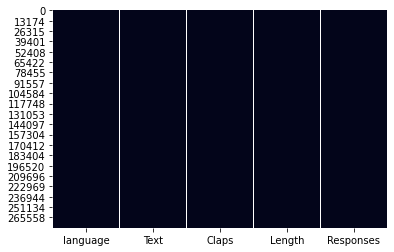

In [ ]:
# validate via missing values graph
sns.heatmap(df_reduced_no_d.isnull(), cbar=False);

In [ ]:
# the function to drop missing values (if there were any) would be:
df_reduced_no_d_no_m=df_reduced_no_d.dropna()

In [ ]:
# eliminating 3 entries with Length = 0, which contain no text, but have not been detected like missing values due to the atypical cell formatting in case of
# a missing value
df_reduced_no_d_no_m = df_reduced_no_d_no_m[df_reduced_no_d_no_m.Text != "\n"]
df_reduced_no_d_no_m = df_reduced_no_d_no_m[df_reduced_no_d_no_m.Text != "N/A\n"]

In [ ]:
df_reduced_no_d_no_m.shape

(66116, 5)

In [ ]:
# since there are only English entries left, the column language can be dropped
df_reduced_no_d_no_m = df_reduced_no_d_no_m.drop(["language"], axis= 1)

In [ ]:
df_reduced_no_d_no_m.head(5)

,Text,Claps,Length,Responses
0,"Private Business, Government and Blockchain\n\...",100,201,0
3,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,0,4854,0
7,"Ascent of data Science, SAS and Big data Analy...",0,533,0
11,Can a robot love us better than another human ...,50,173,0
16,"2017 Big Data, AI and IOT Use Cases\nAn Active...",27,1768,0


### 4.3 Numerical Data Analysis

In [ ]:
# explore the data types of all variables
df_reduced_no_d_no_m.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 66116 entries, 0 to 279572
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       66116 non-null  object
 1   Claps      66116 non-null  int64 
 2   Length     66116 non-null  int64 
 3   Responses  66116 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 2.5+ MB


In the following cells, an univariate numerical data exploration will be performed. At first, a histogram will be plotted for each numerical variable to explore its distribution. The observations and the conclusions to be made from the graphs are the follwoing ones:

1.   It can be seen that the variables mostly have the value 0 or values around 0, which causes the distribution to be very right-skewed. This implies the mean does not necessarily provide a good estimate for the center of the data and is not a representative value for most of the data. In this case, the median should be used to evaluate the center of the data, rather than the mean. This dependence is of importance if having missing values, which cannot be dropped out, but must be filled in instead (will be the case when dealing with the test data). The median would then be a reasonable fill.

2.   Normally, a histogram would serve as a first look at outliers, but in this case, the outliers are obviously only a small percentage of the most common values (the zeros, which domninate), sincd they are not directly visible from the plots. To better explore outliers, box plots will be used.



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6febb20b8>,
      dtype=object)

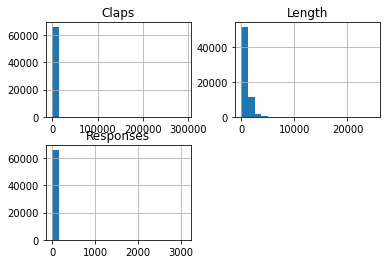

In [ ]:
df_reduced_no_d_no_m.select_dtypes(include='int64').hist(bins=20)

As it can be seen from the box plots below, the observations of the variables Responses and Claps mostly consist of outliers (also confirmed by the 5-numbers summary below the plots). This means, that if the outliers of these variables get truncated based on the factorial IQR (as it is in the outlier truncation function), almost (all) values will turn 0. Thus the outlier of these two values won't be truncated.

The outliers of the variable Length are more, have a higher variance and the problem in the case of the other two variables and will thus be truncated.


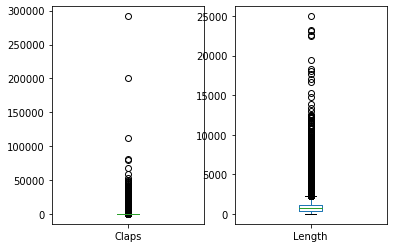

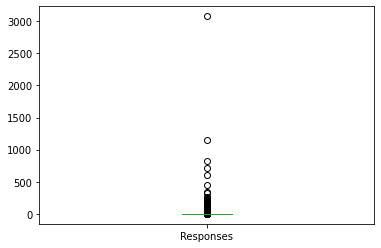

In [ ]:
# plot boxplots for the numeric variables to check for outliers
num_vars = df_reduced_no_d_no_m.select_dtypes(include="int64")
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

In [ ]:
# five number summary to statistically describe the data and get a more precise quantification of the outliers
df_reduced_no_d_no_m.describe()

,Claps,Length,Responses
count,66116.000000,66116.000000,66116.000000
mean,173.143248,923.780628,0.906362
std,1894.701647,871.743769,14.970349
min,0.000000,1.000000,0.000000
25%,0.000000,422.000000,0.000000
50%,6.000000,721.000000,0.000000
75%,65.000000,1159.000000,0.000000
max,291706.000000,24964.000000,3076.000000


**Truncate the outliers of the variable Length**

In [ ]:
# define the columns whose outliers will to be truncated
df_reduced_no_d_no_m['Length'] = df_reduced_no_d_no_m['Length'].astype(np.float64)
floats = [x for x in df_reduced_no_d_no_m.columns if df_reduced_no_d_no_m[x].dtype == 'float64']
# apply the truncate function on each observation of the value Length
df_reduced_no_d_no_m[floats] = df_reduced_no_d_no_m[floats].apply(outlier_truncation, axis=0)
# set the data type of Length back to int64
df_reduced_no_d_no_m['Length'] = df_reduced_no_d_no_m['Length'].astype(np.int64)

**See what has changed after the truncation:**

The skewness of the distribution of the variable Length has decreased (even though still a little skew) and the distribution is still far from a normal one, but the mean of the observations is now slightly more representative of the data center.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd6fea107f0>,
      dtype=object)

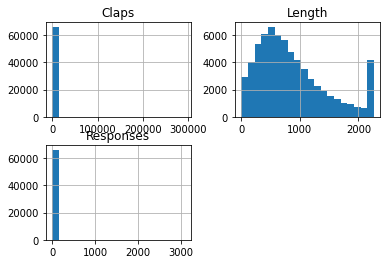

In [ ]:
df_reduced_no_d_no_m.select_dtypes(include='int64').hist(bins=20)

The otliers have been truncated and the box plot graph is closer to the one of a normally distributed variable.

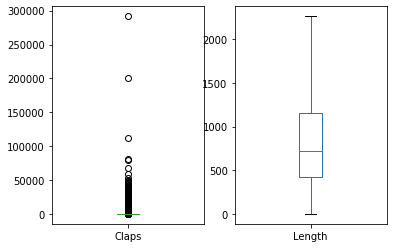

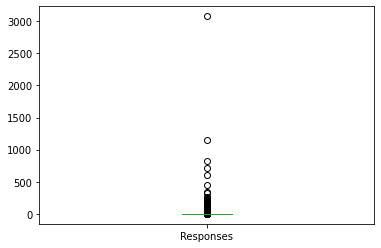

In [ ]:
num_vars = df_reduced_no_d_no_m.select_dtypes(include="int64")
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

Based on the new 5 number summary (see below), the variance of the variable Length has decreased and so has its maximal value respectively the value of its highest outlier.


In [ ]:
df_reduced_no_d_no_m.describe()

,Claps,Length,Responses
count,66116.000000,66116.000000,66116.000000
mean,173.143248,859.610125,0.906362
std,1894.701647,586.873427,14.970349
min,0.000000,1.000000,0.000000
25%,0.000000,422.000000,0.000000
50%,6.000000,721.000000,0.000000
75%,65.000000,1159.000000,0.000000
max,291706.000000,2264.000000,3076.000000


A brief univariate explorative plot of the numeric variables in the train set is provided by the correlation plot below. From the plot it can be seen that that Claps and Resopnses have a a colinearity of 0.57, which also intuitively makes sense - the Responses could truly have impact on the Claps. This serves as a confirmation that it is correct to include the variable Responses in the ML model.

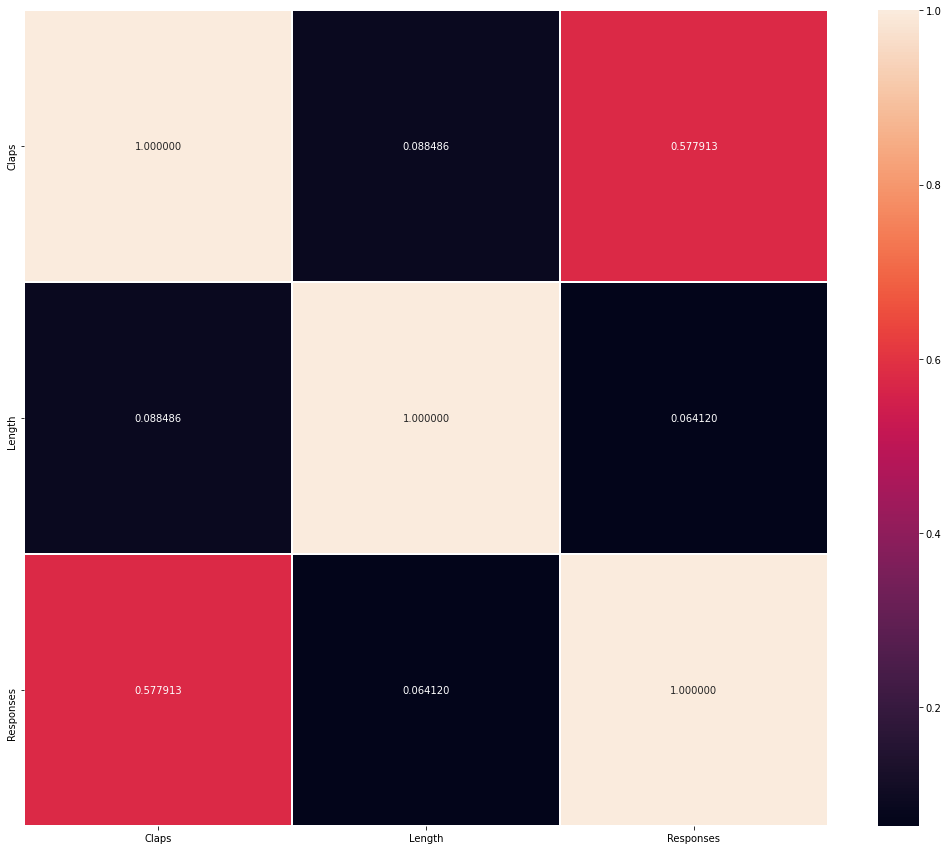

In [ ]:
corr= df_reduced_no_d_no_m.corr()
f,ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corr ,annot=True,linewidth=.5,fmt='1f');

**The numerical variables need to be normalized (min-max-normalization). For this purpose the min and the max value of all numerical input data is needed. Within this context, it is important to consider that the text data will be later transformed into numerical input with the help of embeddings. Then, the min and the max value of the embeddings will also be the range for the min-max-normalization, meaning all numerical values (Claps, Length, Responses) will be scaled between the min and the max value of the embedding matrix.**

### 4.4 Clean the Text Data 

In [ ]:
df_reduced_no_d_no_m.head(5)

,Text,Claps,Length,Responses
0,"Private Business, Government and Blockchain\n\...",100,201,0
3,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,0,2264,0
7,"Ascent of data Science, SAS and Big data Analy...",0,533,0
11,Can a robot love us better than another human ...,50,173,0
16,"2017 Big Data, AI and IOT Use Cases\nAn Active...",27,1768,0


The text entries will be cleaned using the clean_entries function, which is described in detail in the section Functions (at the beginning of the notebook)

In [ ]:
clean = clean_entries(df_reduced_no_d_no_m.Text)

In [ ]:
# detokenize the entries in order to be able to tokenize them later within Keras
df_reduced_no_d_no_m['entry_clean'] = [TreebankWordDetokenizer().detokenize(entry) for entry in clean]

In [ ]:
# save the clean data in a data frame, which can be loaded anytime
df_reduced_no_d_no_m.to_csv('/content/gdrive/My Drive/ADAMS_2020/num_text_clean.csv')

### 4.5 Benchmark

In [ ]:
df_clean = "/content/gdrive/My Drive/ADAMS_2020/num_text_clean.csv"
df_clean = pd.read_csv(df_clean)

In [ ]:
# the variable Text is not needed anymore; only the clean entries can be kept
df_clean = df_clean.drop(["Unnamed: 0", "Text"], axis=1)

In [ ]:
df_clean

,Claps,Length,Responses,entry_clean
0,100,201,0,private business government blockchain major p...
1,0,4854,0,epq draft word http upload wikimedia org wikip...
2,0,533,0,ascent data science sa big data analyst traini...
3,50,173,0,robot love u well another human discuss michel...
4,27,1768,0,big data ai iot use case active list interest ...
...,...,...,...,...
66111,92,984,1,uc berkeley mids immersion fall daniel kent cu...
66112,4,1478,1,analyze extreme skiing snowboard r freeride wo...
66113,567,1995,0,build smart chatbot assistant chatengine ibm w...
66114,42,310,0,ggrepel thing get crowd sometimes useful alway...


In [ ]:
# making sure that there are no missing values (the Tokenizer wouldn't read them later)
df_clean = df_clean.dropna(subset = ["entry_clean"])

The train set will be split in three subsets: train (60%), test (20%) and validation (20%). The model will be trained on the train set. Predictions will be made on the test and validation set to evaluate robustness of the model. If the MSE is similar on both sets, the model can be considered robust. The hyperparameter optimization will be performed according to the validation set, meaning that the early stop will be adjusted based on the imporvement on the validation set in its quaity of a hold-out set. Also, the validation loss will be tracked parellely to the loss on the train set.

In [ ]:
# split the data in train and hold-out (test) set
features=df_clean.drop(['Claps'],axis=1)
target=df_clean['Claps']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=111)

# X sets contain length, responses, entries
# y sets contain claps

In [ ]:
# split the test set in test and validation set

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=111)

In [ ]:
y_val_list = []
y_test_list = []
for i in range (0, len(y_val)):
  value_val = y_val.iloc[i]
  value_test = y_test.iloc[i]
  y_val_list.append(value_val)
  y_test_list.append(value_test)

In [ ]:
# since the features are both textual and numerical data, a separation is needed
# save the textual data 

X_train_text = X_train["entry_clean"]
X_train_text_bm = X_train_text.copy()

X_test_text = X_test["entry_clean"]
X_test_text_bm = X_test_text.copy()

X_val_text = X_val["entry_clean"]
X_val_text_bm = X_val_text.copy()

In [ ]:
# save the numerical data
X_train_num = X_train[["Length", "Responses"]]
X_train_num_bm = X_train_num.copy()

X_test_num = X_test[["Length", "Responses"]]
X_test_num_bm = X_test_num.copy()

X_val_num = X_val[["Length", "Responses"]]
X_val_num_bm = X_val_num.copy()

In [ ]:
# save all numerical variables (features + target) in one data frame, which will be used for the min/max normalization of the numerical variables
train_frame_num = X_train_num.copy()
train_frame_num["Claps"] = y_train.values.copy()
train_frame_num_bm = train_frame_num.copy()

test_frame_num = X_test_num.copy()
test_frame_num["Claps"] = y_test.values.copy()
test_frame_num_bm = test_frame_num.copy()

val_frame_num = X_val_num.copy()
val_frame_num["Claps"] = y_val.values.copy()
val_frame_num_bm = val_frame_num.copy()


In [ ]:
dataframes_bm = rescaled_numeric_input_dataframes(0, 1, train_frame_num_bm, test_frame_num_bm, val_frame_num_bm, X_train_num_bm, X_test_num_bm, X_val_num_bm, y_train, y_test, y_val)

In [ ]:
# create final data frames (series in the case of the y-sets), containing only normalized numeric values, which will be used in the keras model

X_train_num_norm_bm = dataframes_bm[0] 
X_test_num_norm_bm = dataframes_bm[1]
X_val_num_norm_bm = dataframes_bm[2]

y_train_norm_bm = dataframes_bm[3]
y_test_norm_bm = dataframes_bm[4]
y_val_norm_bm = dataframes_bm[5]




Both text data and numeric data need to be pre-processed to be fed to a classifier. For the processing of the numeric data, the function rescaled_numeric_input_dataframes (described in detail in the "Functions" section) will be used to rescale the numeric output and create X and y data frames containing only rescaled numeric data, ready to be fed to the benchmark classifier (and the Keras Model later). 

The text data will be vectorized with the TFIDFVectorizer. The TFIDFVectorizer is a vectorizer going further than the CountVectorizer. The CountVectorizer bases the vectorization on the frequency a word appers in the document with. This results in biasing in favour of most frequent words and ends up in ignoring rare words which could help in processing the data more efficiently.

A solution to this is the TFIDFVectorizer. With the TFIDFVectorizer the vectorized value increases proportionally to count, but is penalized proportionally to word frequency in the whole corpus, meaning that a value is porportional to the word frequency in the document and inversely proportional to frequency of the word in the corpus. This prevents rare words to lose on importance, since they are often representative of a document.

In [ ]:
# preprocessing text data - fitting the vectorizer on the train data and transforming the train, test and validation set based on the fit (see next cell)
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train_text_bm) 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
X_tfidf = vectorizer.transform(X_train_text_bm)
X_test_tfidf = vectorizer.transform(X_test_text_bm)
X_val_tfidf = vectorizer.transform(X_val_text_bm)

Since the classifier which will be used only accepts single inputs, the vectorized text data and the scaled numeric data must be put in one data frame. This is done with the function hstack, which stack arrays/data frames/matricesin sequence horizontally (column wise).



In [ ]:
X_tr_final_bm = hstack([X_tfidf,X_train_num_norm_bm])
X_test_final_bm = hstack([X_test_tfidf,X_test_num_norm_bm])
X_val_final_bm = hstack([X_val_tfidf,X_val_num_norm_bm])

Linear regression with Ridge penalty will be used as a benchmark. The penalty term will be set to its default value (no hyperparameter tuning), since the linear classifier serves as a benchmark and is not the focus of the work.

In [ ]:
clf = Ridge(alpha=1, random_state=241)

In [ ]:
clf.fit(X_tr_final_bm, y_train_norm_bm) 

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=241, solver='auto', tol=0.001)

In [ ]:
rslt_val = clf.predict(X_val_final_bm)
rslt_test = clf.predict(X_test_final_bm)

In [ ]:
# use the function get_mse_on_test_and_validation_set (described in detail above) to get predictions (scaled), inversely scale them and calculate the MSE
get_mse_on_test_and_validation_set(normalized_val_num_frame_bm, normalized_test_num_frame_bm, rslt_val, rslt_test, y_val_list, y_test_list, scaler_bm)

The MSE on the validation set is  7919306.0
The MSE on the test set is  5270164.0


### 4.6 Text Data Preprocessing for Keras

The text data needs to be preprocessed differently for the Keras model than for the benchmark classifier. A Kers-Tokenizer must to the text train set and then the text train, text test and text validation set need to be transformed. Finally, the tokenized sequences need to be padded so that they are compatible to each other shape- and dimension-wise. Further explanations regarding padding and tokenizations will not follow, since both are standard procedures when processing text data for a neural netowork model.

In [ ]:
#count the amount of unique words in all entries
county = []
for i in range (0, len(X_train_text)):
  count = Counter(X_train_text.iloc[i].split())
  county.append(len(count))
sum(county)

10549903

In [ ]:
NUM_WORDS = 100000 # anything higher than this is very computationally expensive

# Create tokenizer object and build vocab from the training set
tokenizer_obj = Tokenizer(NUM_WORDS, oov_token=1)  #  fit the tokenizer to the training entries. The test set might include words that are not part of the training data. The argument oov_token ensures that such new words are mapped to the specified index
tokenizer_obj.fit_on_texts(X_train_text)

In [ ]:
X_tr_text_int = tokenizer_obj.texts_to_sequences(X_train_text)
X_test_text_int = tokenizer_obj.texts_to_sequences(X_test_text)
X_val_text_int = tokenizer_obj.texts_to_sequences(X_val_text)

In [ ]:
max_entry_length = max([len(review) for review in X_tr_text_int])
print('The longest entry of the training set has {} words.'.format(max_entry_length))

The longest entry of the training set has 13275 words.


In [ ]:
# pad the text data
MAX_REVIEW_LENGTH = 13275

X_tr_text_int_pad = pad_sequences(X_tr_text_int, MAX_REVIEW_LENGTH)
X_test_text_int_pad = pad_sequences(X_test_text_int, MAX_REVIEW_LENGTH)
X_val_text_int_pad = pad_sequences(X_val_text_int, MAX_REVIEW_LENGTH)

In [ ]:
X_tr_text_int_pad.shape, X_test_text_int_pad.shape, X_val_text_int_pad.shape

((39668, 13275), (13223, 13275), (13223, 13275))

## 5. Load the Embeddings and Normalize the Numeric Input for Keras

In [ ]:
# load glove embeddings 50 dim

glove_index = {}
with open("/content/gdrive/My Drive/ADAMS_2020/glove.6B.50d.txt",'r', encoding="utf8") as f:
  for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_index[word] = coefs

print('Found %s word vectors.' % len(glove_index))

Found 400000 word vectors.


In [ ]:
# get glove embedding weights using the get_embedding function (described in detail in the section Functions)
glove_weights, _ = get_embedding_matrix(tokenizer_obj, glove_index, NUM_WORDS)

Created embedding matrix of shape (100000, 50)
Encountered 109026 out-of-vocabulary words.


As already mentioned at the end of section 4.3, after the embedding matrix has been created, the min and the max value will be extracted and the numeric data will be rescaled between these two values. This way, the data (which is now all numeric) will on on the same scale, which will enable the model to fit faster.

In [ ]:
# extract min value from the embeddings
min = 0
for p in range (0, glove_weights.shape[0]):
  for q in range (0, glove_weights.shape[1]):
    if glove_weights[p][q] < min:
      min = glove_weights[p][q]

In [ ]:
# extract max value from the embeddings
max = 0
for r in range (0, glove_weights.shape[0]):
  for s in range (0, glove_weights.shape[1]):
    if glove_weights[r][s] > max:
      max = glove_weights[r][s]

In [ ]:
min, max

(-4.625199794769287, 5.0756001472473145)

#### Min-Max-Normalization of Numerical Variables for the Keras Model

In [ ]:
dataframes = rescaled_numeric_input_dataframes(min, max, train_frame_num, test_frame_num, val_frame_num, X_train_num, X_test_num, X_val_num, y_train, y_test, y_val)

In [ ]:
# create final data frames (series in the case of the y-sets), containing only normalized numeric values, which will be used in the keras model

X_train_num_norm = dataframes[0] 
X_test_num_norm = dataframes[1]
X_val_num_norm = dataframes[2]

y_train_norm = dataframes[3]
y_test_norm = dataframes[4]
y_val_norm = dataframes[5]




## 6. Estimate the ML Model

In the case of the benchmark classifier, the transformed text data and the numeric data were stacked in one frame. Neural networks however allow the implementation of features (e.g. recurrent layers), which are particularly useful for text data modeling and could potentially improve the model performance if optimized sufficiently. In addition, an embedding layer belongs to the architecture of an NLP model. Numeric variables cannot and should not go through this layer. They could go through a recurrent layer, but it wouldn't be as beneficial as it is for text data, since the main idea of recurrent NNs (memorizing long term dependencies) makes much more sense within the context of big amount of text data. So, it doesn't make sense to apply a relatively computationally expensive recurrent layer on data, which won't benefit from it much. Thus, in order to make use of all types of data available, it is reasonable to estimate a multiple inputs (two-headed) model. This is achieved in Keras by using Keras' functional API.  

Two separate "sub" neural networks are created for each type of data. The first sub NN operates on the text data. An embedding layer and a recurrent layer are both implemented. The recurrent layer is a CuDNNLSTM-layer - a variation of an LSTM layer - which fits the data significantly faster than an LSTM or a GRU layer. A drawback of CuDNNLSTM is that it only uses tanh as activation function, which is little flexible as it only covers the range from 0 to 1. LSTM and GRU layers have more potential to fit the data better as they both can use various activation functions, but are much more computationally expensive. Thus, CuDNNLSTM is a good alternative when having little computational power.
Drop-out layers are used to prevent overfitting. 

The numeric data flows through dense layers with drop-out layers inbetween. 

Finally, both sub NNs are merged to one, to which only a final output dense layer is added. This then represents the model to be trained and tuned.

The imeplementation of the multiple inputs model is shown below.



In [ ]:
# Some variables to centralize the configuration of deep learning models
NB_HIDDEN = 50
EPOCH = 35
BATCH_SIZE = 128
EMBEDDING_DIM = 50
VAL_SPLIT = 0.25  # fraction of the training set used for validation

In [ ]:
# Using Keras' functional API: two input objects - one for the text data, one for the numeric one
inputA = Input(shape=(MAX_REVIEW_LENGTH,))
inputB = Input(shape=(X_train_num_norm.shape[1],))

In [ ]:
# create the embedding layer
embedding_layer = Embedding(NUM_WORDS, 
                         EMBEDDING_DIM,  
                         embeddings_initializer=Constant(glove_weights), 
                         input_length=MAX_REVIEW_LENGTH, 
                         trainable=False  # we start with frozen weights and relax this choice in model #5
                         )(inputA)

In [ ]:
# first branch operating on textual input

a = CuDNNLSTM(NB_HIDDEN,return_sequences=True)(embedding_layer)
a = (Dropout(0.25))(a)
a = CuDNNLSTM(NB_HIDDEN,return_sequences=True)(a)
a = (Dropout(0.25))(a)
a = CuDNNLSTM(NB_HIDDEN)(a)
a = (Dropout(0.25))(a)
a_m = Model(inputs=inputA, outputs=a)

In [ ]:
# second branch operating on numerical input
 
b = Dense(50, activation="tanh")(inputB)
b = (Dropout(0.5))(b)
b = Dense(25, activation="tanh")(b)
b = (Dropout(0.25))(b)
b_m = Model(inputs=inputB, outputs=b)

In [ ]:
# combine output of the two branches
combined = concatenate([a_m.output, b_m.output])

In [ ]:
# apply a final dense output layer and then train and tune the combined model

z2 = Dense(1, activation="linear")(combined)

In [ ]:
model = Model(inputs=[a_m.input, b_m.input], outputs=z2)

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13275)]      0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13275, 50)    5000000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
cu_dnnlstm (CuDNNLSTM)          (None, 50)           20400       embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
opt = optimizers.Adam(lr=0.001)

In [ ]:
# set loss function to MSE, because the task is regression
model.compile(optimizer=opt, loss='MSE')

In [ ]:
# create a checkpoint callback to save the best model (so that predictions can be generated straight after, without having to fit it once again)
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint("/content/gdrive/My Drive/ADAMS_2020/best_num_textModel.h5",save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, restore_best_weights=True)

In [ ]:
# train the model
story = model.fit([X_tr_text_int_pad, X_train_num_norm],y_train_norm,batch_size=128, verbose=0, epochs=EPOCH, validation_data=([X_val_text_int_pad, X_val_num_norm], y_val_norm), callbacks=[model_checkpoint_callback, early_stop])


The loss on the train and the validation set is plotted below using the function train_test_loss (defined in section Functions). The loss on the train set falls drastically at the beginning, which is typical for the Adam optimizer. The validation loss is constant, which means that the model is not learning and keeps overfitting more and more with each epoch (because the train loss keeps decreasing). This means that the difference between val loss and train loss gets higher and higher and the model fits too closely to the train data and doesn't perform well on unseen data. One possible solution to the problem of not learing is reducing the amount of drop out layers. Hyperparameter optimization will be performed for further changed.

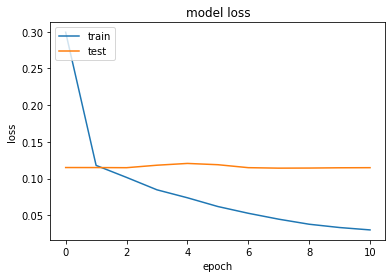

In [ ]:
train_test_loss(story)

In [ ]:
loaded_model = tensorflow.keras.models.load_model('/content/gdrive/My Drive/ADAMS_2020/best_num_textModel.h5')


In [ ]:
pred_val_set = loaded_model.predict([X_val_text_int_pad, X_val_num_norm])
pred_test_set = loaded_model.predict([X_test_text_int_pad, X_test_num_norm])

In [ ]:
get_mse_on_test_and_validation_set(normalized_val_num_frame, normalized_test_num_frame, pred_val_set, pred_test_set, y_val_list, y_test_list)

The MSE on the validation set is  7614620.0
The MSE on the test set is  5427858.0


## 7. Tune the ML Model: **Hyperparameter-Optimization**

In [ ]:
hp_optimization=HP_Optimization(X_train_numerical = X_train_num_norm , X_train_textual = X_tr_text_int_pad,y_train=y_train_norm,
                                X_val_numerical = X_val_num_norm,X_val_textual=X_val_text_int_pad,y_val=y_val_norm,
                                X_test_numerical = X_test_num_norm,X_test_textual=X_test_text_int_pad,y_test_orig_list=y_test_list,y_val_orig_list=y_val_list,
                                X_val_numerical_frame = normalized_val_num_frame, X_test_numerical_frame= normalized_test_num_frame,
                                max_length_review = MAX_REVIEW_LENGTH,num_words= NUM_WORDS,embedding_dim=EMBEDDING_DIM,embedding_weights=glove_weights,
                                scaler = scaler,num_trials= 10)



In [ ]:
results_hp_optimization=hp_optimization.run_hp()

The following architecture is the one delivering best results within the 10 trials of optimization.

In [ ]:
# first branch operating on text input

a = CuDNNLSTM(NB_HIDDEN)(embedding_layer)
a = (Dropout(0.25))(a)
a_m = Model(inputs=inputA, outputs=a)

In [ ]:
# second branch operating on numeric input
# tanh is used as activation function for the purpose of consistency (CuDNNLSTM uses tanh only)
 
b = Dense(50, activation="tanh")(inputB)
b = (Dropout(0.25))(b)
b_m = Model(inputs=inputB, outputs=b)

In [ ]:
# combine output of the two branches
combined = concatenate([a_m.output, b_m.output])

In [ ]:
# apply a Dense layer and then a regression prediction on the combined outputs

z2 = Dense(1, activation="linear")(combined)

In [ ]:
model_tuned = Model(inputs=[a_m.input, b_m.input], outputs=z2)

In [ ]:
model_tuned.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 13275)]      0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 13275, 50)    5000000     input_3[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_23 (CuDNNLSTM)       (None, 13275, 50)    20400       embedding_2[0][0]                
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 13275, 50)    0           cu_dnnlstm_23[0][0]              
______________________________________________________________________________________

In [ ]:
# set loss function to MSE, because the task is regression
model_tuned.compile(optimizer=opt, loss='MSE')

In [ ]:
# train the modelmodel = Model(inputs=[a_m.input, b_m.input], outputs=z2)
story_tuned = model_tuned.fit([X_tr_text_int_pad, X_train_num_norm],y_train_norm,batch_size=128,verbose =0, epochs=EPOCH, validation_data=([X_val_text_int_pad, X_val_num_norm], y_val_norm), callbacks=[model_checkpoint_callback, early_stop])


The loss on the train set again falls drastically at the beginning, but as already said this is typical for the Adam optimizer. The validation loss shows decreasing tendency, but also jumps across all epochs. The decrease means that the model is learning, but the jumps imply overfitting (because the validation loss in epoch t is higher than in epoch t-1), which means that the model fits too closely to the train data and doesn't perform well on unseen data. The hyperparameters of the model need to be optimized further for an improved performance. An extensive optimization is, however, only possible whe sufficient computational resources are available.

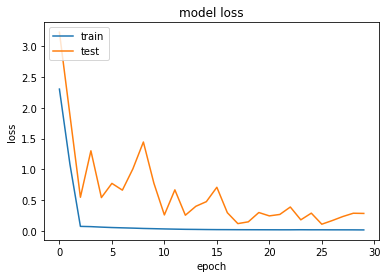

In [ ]:
train_test_loss(story_tuned)

In [ ]:
loaded_tuned_model = tensorflow.keras.models.load_model('/content/gdrive/My Drive/ADAMS_2020/best_num_textModel.h5')


In [ ]:
pred_val_set_tuned = loaded_tuned_model.predict([X_val_text_int_pad, X_val_num_norm])
pred_test_set_tuned = loaded_tuned_model.predict([X_test_text_int_pad, X_test_num_norm])

In [ ]:
get_mse_on_test_and_validation_set(normalized_val_num_frame, normalized_test_num_frame, pred_val_set_tuned, pred_test_set_tuned, y_val_list, y_test_list, scaler)

The MSE on the validation set is  7718051.0
The MSE on the test set is  5123486.0


### **Summary of Results**

**Benchmark**:

The MSE on the validation set is  7919306.0

The MSE on the test set is  5270164.0

**NN without tuning:**

The MSE on the validation set is  7614620.0

The MSE on the test set is  5427858.0

**NN with tuning:**

The MSE on the validation set is  7718051.0

The MSE on the test set is  5123486.0


To create a parallel between results and theory the following can be said:

in general, linear classifiers perform decently on text data, since it is very high dimensional and thus often linearily separable. Also, over-fitting is usually well prevented in the case of linear ridge regression since the classifier is not as powerful unlike non-linear classifiers (so it cannnot fit the data too closely). Non-linear classifiers such as neural networks could potentially fit the model better, but require extensive hyperparameter optimization. This could explain the similar performance of the benchmark and the not tuned model. In the current case, hyperprameter optimization has only been performed for 10 trials, which is insufficient to optimize the performance of a NN with over 20.000 trainable parmeters, which result from the embedding and recurrent layers used. In addition, as already said earlier, CuDNNLSTM layers use much less computational power, but are more limited in their quality to fit the data because the only activation function they can use, is tanh. Still, as the results show the performance of the tuned model performs overall the best, even if just slightly better than the benchmark and the not tuned model. With more trials and regular LSTM (or other (bidirectional) recurrent layers), the performance could improve more significantly. 

## 8. Test Data

Most of this section is very similar to section 4.

### 8.1 Data Analysis and Data Preprocessing

In [ ]:
df_test.head(5)

,Unnamed: 0,index,Author,PublicationDetails,Responses,Header,Text,Length
0,0,0,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 31, 2017",627 responses,Why Everyone Missed the Most Mind-Blowing Feat...,There’s one incredible feature of cryptocurren...,23401
1,1,1,Noam Levenson,"Noam Levenson in HackerNoon.comDec 6, 2017",156 responses,NEO versus Ethereum: Why NEO might be 2018’s s...,"<img class=""progressiveMedia-noscript js-progr...",23972
2,2,2,Daniel Jeffries,"Daniel Jeffries in HackerNoon.comJul 21, 2017",176 responses,The Cryptocurrency Trading Bible,So you want to trade cryptocurrency?You’ve see...,402
3,3,5,Haseeb Qureshi,"Haseeb Qureshi in HackerNoon.comFeb 19, 2018",72 responses,Stablecoins: designing a price-stable cryptocu...,A useful currency should be a medium of exchan...,19730
4,4,7,William Belk,"William Belk in HackerNoon.comJan 28, 2018",19 responses,Chaos vs. Order — The Cryptocurrency Dilemma,Crypto crypto crypto crypto. It’s here. It’s h...,5324


In [ ]:
df_test.shape

(514, 8)

#### Feature Elimination and Extraction

In [ ]:
# leave only the needed columns
df_test_reduced = df_test[["Text", "Length", "Responses"]]

In [ ]:
df_test_reduced.head(5)

,Text,Length,Responses
0,There’s one incredible feature of cryptocurren...,23401,627 responses
1,"<img class=""progressiveMedia-noscript js-progr...",23972,156 responses
2,So you want to trade cryptocurrency?You’ve see...,402,176 responses
3,A useful currency should be a medium of exchan...,19730,72 responses
4,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19 responses


In [ ]:
# the column Responses must contain numerical values only (without the String "responses")
df_test_reduced[["keep", 'delete']] = df_test_reduced.copy()['Responses'].str.split(' ', n=1, expand=True)
df_test_reduced = df_test_reduced.copy().drop(["delete"], axis=1)
df_test_reduced = df_test_reduced.copy().drop(["Responses"], axis=1)
df_test_reduced = df_test_reduced.copy().rename(columns={"keep": "Responses"})
df_test_reduced.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:2963: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Text,Length,Responses
0,There’s one incredible feature of cryptocurren...,23401,627
1,"<img class=""progressiveMedia-noscript js-progr...",23972,156
2,So you want to trade cryptocurrency?You’ve see...,402,176
3,A useful currency should be a medium of exchan...,19730,72
4,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19


As mentioned earlier in section 4, the library Textblob is used for the purpose of language detection across the test set.

In [ ]:
from textblob import TextBlob

In [ ]:
# use libray Textblob to determine the languages of the entries in the test set
languages=[]
for i in range(0,df_test_reduced.shape[0]):
  lang = TextBlob(df_test_reduced["Text"].iloc[i]) # creating a Textblob object
  language = lang.detect_language() # using function detect_language() of the Textblob object
  languages.append(language)
df_test_reduced["Language"] = languages

In [ ]:
df_test_reduced.head(5)

,Text,Length,Responses,Language
0,There’s one incredible feature of cryptocurren...,23401,627,en
1,"<img class=""progressiveMedia-noscript js-progr...",23972,156,en
2,So you want to trade cryptocurrency?You’ve see...,402,176,en
3,A useful currency should be a medium of exchan...,19730,72,en
4,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19,en


In [ ]:
df_test_reduced["Language"].value_counts()

en       511
pt         1
zh-TW      1
ja         1
Name: Language, dtype: int64

**The test set only contains three entries written in a language different than English. Two of them (chinese and portguese) can be translated by the Google Translate API, one (japanese) cannot be (the problem with the instability of the API was explained in section 4.1). These two entries will be thus translated and the predictions will be made on the translated version.**

In [ ]:
df_test_reduced[df_test_reduced.Language!="en"]

,Text,Length,Responses,Language
196,原文刊載於《GQ》網站：吃貨老司機應該要知道的好地方：Good Food You不久之前，這...,396,NaN,zh-TW
198,Bebi a noite como se fosse Coca-Cola. Mastigue...,278,NaN,pt
434,Netflixにおける日本語字幕の導入Netflix Technology Blog in ...,17725,NaN,ja


In [ ]:
translator = Translator() # initialize a Translator object

In [ ]:
df_test_reduced.Text.loc[196] = translator.translate(df_test_reduced.copy().Text.loc[196]).text

In [ ]:
df_test_reduced.Text.loc[196] # translation has been successful

'The original text was published on the "GQ" website: Good place that old food drivers should know: Good Food You Not long ago, this was just a treasure hunt base for chefs and gluttons in the dining circle. "There is an importer who sells a lot of European ingredients, you can pick and choose." They said so, and as a result, the busy office hidden in the alleys of Tingzhou Road, always piled with large and small inbound and outbound cardboard boxes, became regular customers. Chatting, picking goods, looking for new ingredients, "My dad said he can\'t refuse customers." Sandy, the second-generation successor, said, "But then it really affected the delivery, and I couldn\'t greet him, so I opened this one in the alley. Store.” When Sandy said this, the legendary "Chef" Abang was snickering, turning his head and pointing to himself: "I am one of the guests." Well, actually I am too (shangshou), but I was after they opened the store, and a foodie friend recommended: "Hey, there is a food 

In [ ]:
df_test_reduced.Text.loc[198] = translator.translate(df_test_reduced.Text.loc[198]).text

In [ ]:
df_test_reduced.Text.loc[198] # translation has been successful

'I drank the night like it was Coca-Cola. I chewed on stars like ice chips. I opened my eyes as if they were headlights. And I broke the glass as if nothing else needed to exist. I have to give up looking for easy answers. I fear that I will never be able to avoid disasters.'

In [ ]:
df_test_reduced.Text.loc[434] = translator.translate(df_test_reduced.Text.loc[434]).text

In [ ]:
df_test_reduced.Text.loc[434] #translation has not been successful => demonstrates once again the problem with Google Translate API

'Netflixにおける日本語字幕の導入Netflix Technology Blog in Netflix TechBlogFollowMay 14, 2018 · 36 min read(Please note that this article is a localized (to Japanese) version of a corresponding tech blog article in the English language)Netflixでは、2015年9月の日本における配信サービス開始時から日本語字幕を提供しています。 今回のブログでは、日本語字幕提供に至るまでの技術的な取り組みについて説明します。 字幕ソースファイルの仕様、字幕ソースファイルからNetflix配信用字幕への変換モデル、Netflixにおける日本語字幕の納品モデルなどを取り上げます。さらに、W3C字幕規格Timed Text Markup Language 2 (TTML2)導入に向けた対応についても触れます。2014年の終盤にかけて、Netflixでは2015年9月に予定していた日本での配信開始に向け、技術的な機能実現を進めていました。 当時、日本市場で展開している他社ストリーミングサービスの字幕品質が問題となっていることは十分認識していました。 その上でNetflixの高い品質基準を維持するために、日本における上質な動画配信サービスの慣例となるべく、日本語字幕にとっての”必須”機能をすべて導入する覚悟で準備を始めました。 それらは、下記必要条件への追加条件として導入したものです。字幕は動画と分けてクライアントに納品 (すなわち、焼き付け字幕は不可)字幕のソースファイル形式は、将来性を確保するためにもすべてテキスト形式でNetflixに納品日本語字幕の必須機能概要市場調査、日本語言語およびメディア関連の専門家アドバイスをまとめた結果、日本語字幕に関する5つの必須機能が明らかになりました。 これから説明するその5つの機能とは、ルビ、傍点、縦書き、斜体、縦中横 (縦字幕の数字を横書きで表示) です。 これらの機能を実現することは、従来の課題を一層複雑にする大きなチャレンジとなりました。ルビルビは特定の言葉を説明するためのものです。 たとえば、なじみのない言葉や外来語、スラングの意

#### Treat Duplicates and Missing Values

In [ ]:
# check how many missing values there are
# only the variable Reponses contains missing values
df_test_reduced.isnull().sum()

Text          0
Length        0
Responses    82
Language      0
dtype: int64

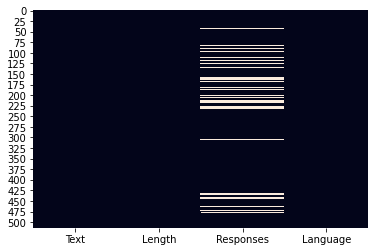

In [ ]:
# validate via missing values graph
sns.heatmap(df_test_reduced.isnull(), cbar=False);

In [ ]:
df_test_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       514 non-null    object
 1   Length     514 non-null    int64 
 2   Responses  432 non-null    object
 3   Language   514 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.2+ KB


As it can be seen from the info(), the variable Responses is of type object. It needs to be transformed into an integer to be used as a numeric variable. The problem with the missing values cannot be solved by dropping the observations, since this is the test set. A solution is to fill them in with a metric of the center of the variable's observations (e.g. mean, median). As already explained in section 4, the distribution of the varible needs to be looked at before deciding on this. In the case of a skewed distribution, it is better to use the median. Below a histogram of the variable Responses can be seen. The distribution is right-skewed, so the median of the value Responses will be used to fill in the missing values.

In [ ]:
# finding the median
a = df_test_reduced.copy()[df_test_reduced.Responses.isnull() == False]
a['Responses'] = a['Responses'].str.replace(',','')
a['Responses'] = a['Responses'].astype(np.int64)
rs_median = a["Responses"].median(axis=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd682a79828>,
      dtype=object)

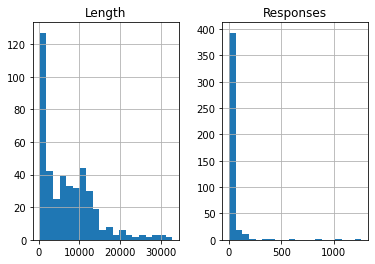

In [ ]:
a.select_dtypes(include='int64').hist(bins=20)

In [ ]:
# replacing the missing values by the median
df_test_reduced['Responses'] = df_test_reduced['Responses'].str.replace(',','')
df_test_reduced["Responses"] = df_test_reduced.copy()["Responses"].fillna(value = round(rs_median))

In [ ]:
# checking whether the missing values are gone: they are
df_test_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       514 non-null    object
 1   Length     514 non-null    int64 
 2   Responses  514 non-null    object
 3   Language   514 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.2+ KB


In [ ]:
df_test_reduced['Responses'] = df_test_reduced['Responses'].astype(np.int64)

In [ ]:
# dropping the column language, since all entries are in English
df_test_reduced=df_test_reduced.drop(["Language"], axis= 1)

In [ ]:
df_test_reduced.head(5)

,Text,Length,Responses
0,There’s one incredible feature of cryptocurren...,23401,627
1,"<img class=""progressiveMedia-noscript js-progr...",23972,156
2,So you want to trade cryptocurrency?You’ve see...,402,176
3,A useful currency should be a medium of exchan...,19730,72
4,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19


#### Numerical Data Analysis

Everything that has been said in the numerical data analysis of the train set (section 4.3) is also valid for the test set. The executed functions and the used plots are also the same. Thus, no detailed explanation will follow.

In [ ]:
# explore the data types of all variables
df_test_reduced.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       514 non-null    object
 1   Length     514 non-null    int64 
 2   Responses  514 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 12.2+ KB


**Before outlier treatment**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69b89898d0>,
      dtype=object)

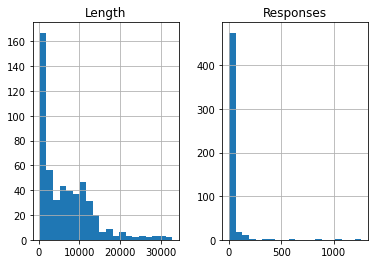

In [ ]:
# plot histograms of the numerical variables to explore their ditribution
# => the variables Length and Responses mostly have the value 0 
df_test_reduced.select_dtypes(include='int64').hist(bins=20)

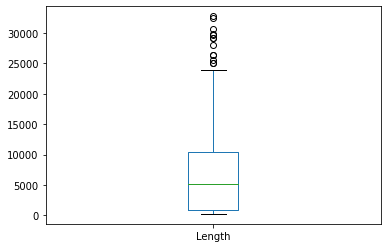

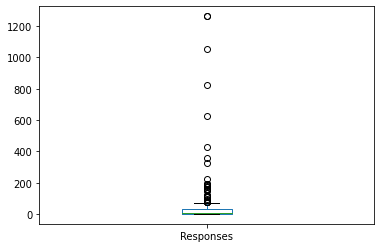

In [ ]:
# plot boxplots for the numeric variables to check for outliers

num_vars = df_test_reduced.select_dtypes(include="int64")
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

In [ ]:
df_test_reduced.describe()

,Length,Responses
count,514.000000,514.000000
mean,6545.963035,31.869650
std,6449.069641,108.265145
min,251.000000,1.000000
25%,908.750000,3.000000
50%,5228.000000,7.500000
75%,10433.250000,32.000000
max,32766.000000,1263.000000


**Execute outlier truncation of the variable Length**

In [ ]:
# define the columns whose outliers will to be truncated
df_test_reduced['Length'] = df_test_reduced['Length'].astype(np.float64)
floats = [x for x in df_test_reduced.columns if df_test_reduced[x].dtype == 'float64']
# apply the truncate function on each observation of the value Length
df_test_reduced[floats] = df_test_reduced[floats].apply(outlier_truncation, axis=0)
# set the data type of Length back to int64
df_test_reduced['Length'] = df_test_reduced['Length'].astype(np.int64)

**See what has changed after the truncation**

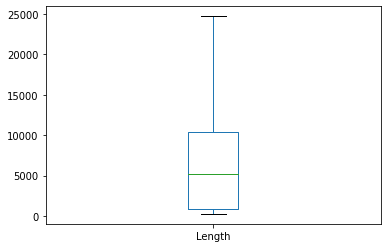

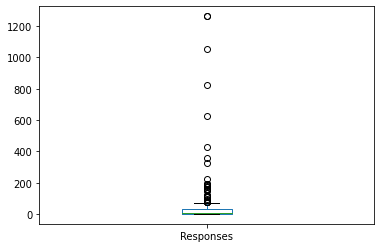

In [ ]:
num_vars = df_test_reduced.select_dtypes(include="int64")
half = np.ceil(num_vars.shape[1] / 2).astype(int)  # for cosmetic reasons we split the plots into two rows
num_vars.iloc[:, 0:half].plot(kind = 'box', subplots=True);
num_vars.iloc[:, half:num_vars.shape[1]].plot(kind = 'box', subplots=True);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69b4053fd0>,
      dtype=object)

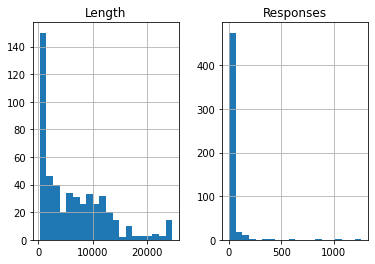

In [ ]:
df_test_reduced.select_dtypes(include='int64').hist(bins=20)

In [ ]:
# check what has changed after the truncation
# => the variance of the variable Length has decreased and so has its maximal value respectively the value of its hughest outlier
df_test_reduced.describe()

,Length,Responses
count,514.000000,514.000000
mean,6450.764591,31.869650
std,6130.950696,108.265145
min,251.000000,1.000000
25%,908.750000,3.000000
50%,5228.000000,7.500000
75%,10433.250000,32.000000
max,24720.000000,1263.000000


**The numerical variables need to be normalized (min-max-normalization). For this purpose the min and the max value of all numerical input data is needed. The text data will be later transformed into numerical one with the help of embeddings. Then, the min and the max value of the embeddings will also be the range for the min-max-normalization, meaning all numerical values (Claps, Length, Responses) will be scaled between the min and the max value of the embeddings.**

#### Clean the Text Data 

In [ ]:
df_test_reduced.head(5)

,Text,Length,Responses
0,There’s one incredible feature of cryptocurren...,23401,627
1,"<img class=""progressiveMedia-noscript js-progr...",23972,156
2,So you want to trade cryptocurrency?You’ve see...,402,176
3,A useful currency should be a medium of exchan...,19730,72
4,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19


In [ ]:
clean_test = clean_entries(df_test_reduced.Text)

****************************************
Cleaning 514 entries.
Processed 500 entries
DONE
****************************************


In [ ]:
# detokenize the entries in order to be able to tokenize them later within Keras
df_test_reduced['entry_clean'] = [TreebankWordDetokenizer().detokenize(entry) for entry in clean_test]

In [ ]:
df_test_reduced.to_csv('/content/gdrive/My Drive/ADAMS_2020/test_clean.csv')

#### Text Data Preprocessing for Keras

In [ ]:
test_clean = "/content/gdrive/My Drive/ADAMS_2020/test_clean.csv"
test_clean = pd.read_csv(test_clean)

In [ ]:
test_clean.head(5)

,Unnamed: 0,Text,Length,Responses,entry_clean
0,0,There’s one incredible feature of cryptocurren...,23401,627,one incredible feature cryptocurrencies almost...
1,1,"<img class=""progressiveMedia-noscript js-progr...",23972,156,onchainneo founder da hongfei erik zhang found...
2,2,So you want to trade cryptocurrency?You’ve see...,402,176,want trade cryptocurrency see eye pop return w...
3,3,A useful currency should be a medium of exchan...,19730,72,useful currency medium exchange unit account s...
4,4,Crypto crypto crypto crypto. It’s here. It’s h...,5324,19,crypto crypto crypto crypto happen big way fas...


In [ ]:
# drop all unnecessary columns
test_clean = test_clean.drop(["Unnamed: 0", "Text"], axis = 1)

In [ ]:
test_clean

,Length,Responses,entry_clean
0,23401,627,one incredible feature cryptocurrencies almost...
1,23972,156,onchainneo founder da hongfei erik zhang found...
2,402,176,want trade cryptocurrency see eye pop return w...
3,19730,72,useful currency medium exchange unit account s...
4,5324,19,crypto crypto crypto crypto happen big way fas...
...,...,...,...
509,9025,181,startup founder ever suppose give even one glo...
510,5571,24,embark startup journey know tackle first long ...
511,475,24,fuck startup extravagant party crazy site even...
512,13483,116,note post glorify prostitution criticise start...


In [ ]:
# since the features are both textual and numerical data, a separation is needed
# save the textual data 
test_clean_text = test_clean["entry_clean"]
test_clean_num = test_clean[["Length", "Responses"]]

In [ ]:
test_clean_text_int = tokenizer_obj.texts_to_sequences(test_clean_text)

In [ ]:
# pad the text data

test_clean_text_int_pad = pad_sequences(test_clean_text_int, MAX_REVIEW_LENGTH)

#### Min-Max-Normalization of Numerical Variables

As mentioned earlier at the end of section 4.3 the numerical variables will be normalized according to the min max normalization. The min and the max value in the created embeddings will represent the min and max values, between which the variables will be rescaled. The values from the train set embeddings are used, so that both train and test data are on the same scale.

In [ ]:
# scale the numerical values in the test set using the scaler fitted on the train and validation set
normalized_test_clean_num = scaler.transform(test_clean_num)

In [ ]:
responses_norm = []
for m in range (0, normalized_test_clean_num.shape[0]):
  resp_norm = normalized_test_clean_num[m][1]
  responses_norm.append(resp_norm)

X_test_num["Responses_Norm"] = responses_norm

In [ ]:
length_norm = []
for m in range (0, normalized_test_clean_num.shape[0]):
  len_norm = normalized_test_clean_num[m][0]
  length_norm.append(len_norm)

X_test_num["Length_Norm"] = length_norm_val

In [ ]:
prediction = loaded_tuned_model.predict([test_clean_text_int_pad, X_test_num])
prediction=prediction.reshape(prediction.shape[0])

In [ ]:
prediction_claps_test = []
for i in range (0, len(prediction)):
    pred_claps_test = prediction[i]
    prediction_claps_test.append(pred_claps_test)


In [ ]:
X_test_num["Predicted_Claps_Norm"] = prediction_claps_test

In [ ]:
# leave only the predictions
X_test_num = X_test_num.drop(["Length_Norm"], axis =1)
X_test_num = X_test_num.drop(["Responses_Norm"], axis =1)

In [ ]:
# the results must be scaled back, since real number of claps/likes is not scaled
predictions = scaler.inverse_transform(X_test_num)

In [ ]:
prediction_claps_inverse_test = []

for i in range (0, len(predictions)):
  pred_test = predictions[i][1]
  prediction_claps_inverse_test.append((round(pred_test)))

In [ ]:
prediction_claps_inverse_test

[406.0,
 405.0,
 3.0,
 405.0,
 383.0,
 405.0,
 297.0,
 383.0,
 405.0,
 3.0,
 4.0,
 4.0,
 5.0,
 405.0,
 404.0,
 397.0,
 399.0,
 404.0,
 3.0,
 403.0,
 397.0,
 90.0,
 405.0,
 405.0,
 250.0,
 405.0,
 393.0,
 403.0,
 3.0,
 4.0,
 3.0,
 36.0,
 404.0,
 402.0,
 401.0,
 404.0,
 404.0,
 3.0,
 400.0,
 3.0,
 393.0,
 3.0,
 404.0,
 337.0,
 3.0,
 403.0,
 3.0,
 3.0,
 3.0,
 388.0,
 24.0,
 3.0,
 3.0,
 404.0,
 404.0,
 3.0,
 403.0,
 5.0,
 3.0,
 403.0,
 385.0,
 314.0,
 333.0,
 405.0,
 330.0,
 3.0,
 4.0,
 392.0,
 4.0,
 357.0,
 369.0,
 3.0,
 3.0,
 3.0,
 3.0,
 396.0,
 3.0,
 248.0,
 3.0,
 3.0,
 3.0,
 374.0,
 4.0,
 3.0,
 3.0,
 394.0,
 3.0,
 3.0,
 8.0,
 334.0,
 3.0,
 11.0,
 352.0,
 3.0,
 3.0,
 3.0,
 4.0,
 403.0,
 144.0,
 345.0,
 403.0,
 7.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 42.0,
 3.0,
 4.0,
 288.0,
 3.0,
 403.0,
 3.0,
 3.0,
 361.0,
 3.0,
 306.0,
 3.0,
 89.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 333.0,
 30.0,
 3.0,
 399.0,
 396.0,
 3.0,
 392.0,
 3.0,
 3.0,
 4.0,
 3.0,
 395.0,
 3.0,
 382.0,
 3.0,
 3.0,
 3.0,
 3.0,
 

In [ ]:
index_list=[]
for i in range (0, len(df_test)):
  index = i 
  index_list.append(index)


In [ ]:
prediction = pd.DataFrame(index_list, columns=["index"])

In [ ]:
prediction["Claps"] = prediction_claps_inverse_test

In [ ]:
prediction_df = prediction.to_csv('/content/gdrive/My Drive/ADAMS_2020/prediction.csv')